Adjust the boundaries according to Table 3, to get the desired optimal solutions.

C:\Users\spyro\AppData\Local\Temp\ipykernel_21972\3675418123.py:48: RuntimeWarning: overflow encountered in scalar multiply
  psi_value = (c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 / (sqrt(2*pi) * gamma(x3) * x3) *
C:\Users\spyro\AppData\Local\Temp\ipykernel_21972\3675418123.py:49: RuntimeWarning: overflow encountered in scalar multiply
  K_half_plus * term1 - sign_x1 * c**(x3+0.5) * exp(sign_x1*c) * (1+u)**(1+x3) /
C:\Users\spyro\AppData\Local\Temp\ipykernel_21972\3675418123.py:48: RuntimeWarning: invalid value encountered in scalar subtract
  psi_value = (c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 / (sqrt(2*pi) * gamma(x3) * x3) *
C:\Users\spyro\AppData\Local\Temp\ipykernel_21972\3675418123.py:51: RuntimeWarning: overflow encountered in scalar multiply
  sign_x1 * c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 /
C:\Users\spyro\AppData\Local\Temp\ipykernel_21972\3675418123.py:48: RuntimeWarning: invalid value encountered in scalar multiply
  psi_value = (c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x

Iteration 1: Current parameters: [0.11958185 0.12169794 0.98826872], Convergence: 0.00392355272153222


C:\Users\spyro\AppData\Local\Temp\ipykernel_21972\3675418123.py:48: RuntimeWarning: overflow encountered in scalar power
  psi_value = (c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 / (sqrt(2*pi) * gamma(x3) * x3) *


Iteration 2: Current parameters: [0.11958185 0.12169794 0.98826872], Convergence: 0.001509237961619097
Iteration 3: Current parameters: [0.11958185 0.12169794 0.98826872], Convergence: 0.012314158903631
Iteration 4: Current parameters: [0.11958185 0.12169794 0.98826872], Convergence: 0.011315696964556995
Iteration 5: Current parameters: [0.11958185 0.12169794 0.98826872], Convergence: 0.011506787616039807
Iteration 6: Current parameters: [0.11958185 0.12169794 0.98826872], Convergence: 0.014748150943844624
Iteration 7: Current parameters: [0.11958185 0.12169794 0.98826872], Convergence: 0.019853585183414253
Iteration 8: Current parameters: [0.11958185 0.12169794 0.98826872], Convergence: 0.019722763892138048
Iteration 9: Current parameters: [0.13125517 0.13699143 0.73895309], Convergence: 0.018305545610191168
Iteration 10: Current parameters: [0.10413374 0.14723305 0.99903232], Convergence: 0.026263511590542216
Iteration 11: Current parameters: [0.10413374 0.14723305 0.99903232], Conve

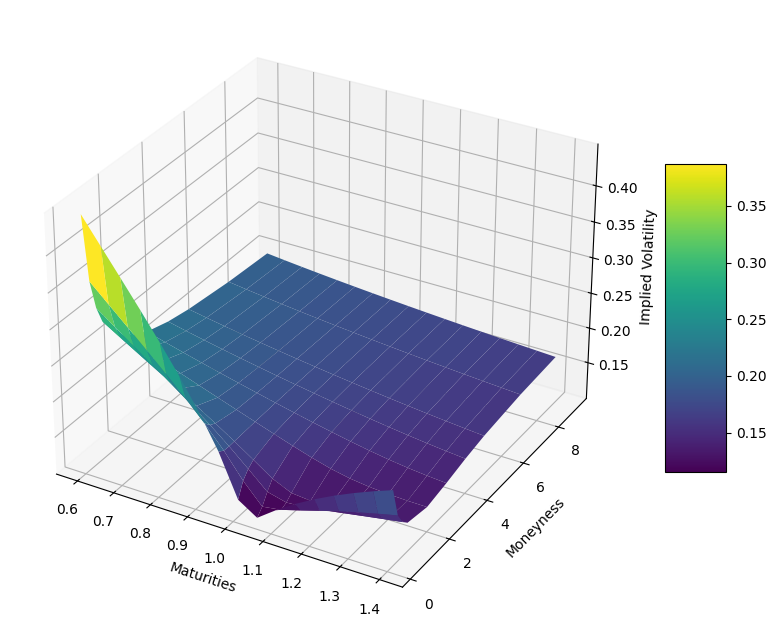

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, brentq
from scipy.integrate import quad
from scipy.stats import norm
from scipy.special import kv, gamma
from math import exp, sqrt, pi, log, isfinite

# Load the data
file_path = r'C:\Users\spyro\OneDrive - University of Edinburgh\Dissertation\Week 6 - Calibration\target_all.xlsx'
df_raw = pd.read_excel(file_path, engine='openpyxl')

# Drop rows with NaN values
df = df_raw.dropna()

# Extract maturities and moneyness
maturities = np.array(df.iloc[:, 0])
moneyness = np.array(df.columns[1:], dtype=float)

# Extract IV_target
IV_target = np.array(df.iloc[:, 1:], dtype=float)

# Define the degenerate hypergeometric function
def degenerate_hypergeometric_function(y1, y2, y3, p1, p2):
    def integrand(x):
        try:
            return (x ** (y1 - 1) * (1 - x) ** (y3 - y1 - 1) *
                    (1 - p1 * x) ** (-y2) * exp(p2 * x))
        except OverflowError:
            return np.inf
    result, error = quad(integrand, 0, 1)
    return (gamma(y3) / (gamma(y1) * gamma(y3 - y1))) * result

# Define Psi function
def Psi(x1, x2, x3):
    try:
        c = abs(x1) * sqrt(2 + x2**2)
        u = x2 / sqrt(2 + x2**2)
        sign_x1 = np.sign(x1)

        term1 = degenerate_hypergeometric_function(x3, 1-x3, 1+x3, (1+u)/2, -sign_x1*c*(1+u))
        term2 = degenerate_hypergeometric_function(1+x3, 1-x3, 2+x3, (1+u)/2, -sign_x1*c*(1+u))

        K_half_plus = kv(x3 + 0.5, c)
        K_half_minus = kv(x3 - 0.5, c)

        psi_value = (c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 / (sqrt(2*pi) * gamma(x3) * x3) *
                     K_half_plus * term1 - sign_x1 * c**(x3+0.5) * exp(sign_x1*c) * (1+u)**(1+x3) /
                     (sqrt(2*pi) * gamma(x3) * (1+x3)) * K_half_minus * term2 +
                     sign_x1 * c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 /
                     (sqrt(2*pi) * gamma(x3) * x3) * K_half_minus * term1)
    except (OverflowError, ValueError): #OverflowError:
        psi_value = np.inf
    return psi_value

# Define the European call option price function
def european_call_option_price(S0, K, T, r, theta, sigma, nu):
    try:
        a = theta / sqrt(sigma**2 + nu * theta**2 / 2)
        s = sigma**2 / sqrt(sigma**2 + nu * theta**2 / 2)
        c1 = nu * (a + s)**2 / 2
        c2 = nu * a**2 / 2
        
        d = (log(S0/K) + r*T + (T/nu) * log((1-c1)/(1-c2))) / s
        
        call_price = (S0 * Psi(d * sqrt((1-c1)/nu), (a + s) * sqrt(nu/(1 - c1)), T/nu) -
                      K * exp(-r*T) * Psi(d * sqrt((1-c2)/nu), a * sqrt(nu/(1 - c2)), T/nu))

    except (OverflowError, ValueError):
        call_price = np.inf
    return call_price

# Fix S0 and r
S0 = 5639.17
rfr = np.array([5.45, 5.38, 5.17, 4.9541, 4.5955, 4.3423, 4.2219, 4.1448, 4.1164, 4.1769])/100

# Define RMSE function to minimize
def rmse(params):
    theta, sigma, nu = params
    if theta < 1/nu - sigma**2 / 2:
        error = 0
        count = 0
        rfr = np.array([5.45, 5.38, 5.17, 4.9541, 4.5955, 4.3423, 4.2219, 4.1448, 4.1164, 4.1769])/100
        for i, T in enumerate(maturities):
            for j, M in enumerate(moneyness):
                K = S0 / M
                r = rfr[i]
                market_price = european_call_option_price(S0, K, T, r, theta, sigma, nu)
                model_iv = implied_volatility(S0, K, T, r, market_price)
                target_iv = IV_target[i, j]
                if not np.isnan(model_iv) and not np.isnan(target_iv):
                    error += (model_iv - target_iv) ** 2
                    count += 1
        if count == 0:
            return 10000
        else:
            return np.sqrt(error / count)
    else:
        return 10000

# Define implied volatility calculation using Black-Scholes model
def implied_volatility(S0, K, T, r, observed_price):
    def iv_objective(sigma):
        return black_scholes_call(S0, K, T, r, sigma) - observed_price
    try:
        return brentq(iv_objective, 0.01, 2.0)  # Search between 1% and 200% volatility
    except ValueError:
        return np.nan  # Return NaN if no solution is found

# Define Black-Scholes call option price function
def black_scholes_call(S0, K, T, r, sigma):
    if T <= 0:
        return max(S0 - K, 0)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Define parameter bounds
bounds = [(-2, 2), (0.01, 0.4), (0.06, 4)]

# Callback function to show progress
def progress_callback(xk, convergence):
    global iteration
    iteration += 1
    print(f"Iteration {iteration}: Current parameters: {xk}, Convergence: {convergence}")

# Initialize iteration counter
iteration = 0

# Perform the optimization using Differential Evolution
result = differential_evolution(rmse, bounds, callback=progress_callback) #, strategy='best1bin', maxiter=4000, popsize=50, tol=1e-4,

# Extract the optimized parameters
theta_opt, sigma_opt, nu_opt = result.x

print(f"Optimized Parameters:\ntheta: {theta_opt}\nsigma: {sigma_opt}\nnu: {nu_opt}")

# Calculate the implied volatility surface using the optimized parameters
implied_vols_opt = np.zeros((len(maturities), len(moneyness)))

for i, T in enumerate(maturities):
    for j, M in enumerate(moneyness):
        K = S0 / M
        r = rfr[i]
        market_price = european_call_option_price(S0, K, T, r, theta_opt, sigma_opt, nu_opt)
        implied_vols_opt[i, j] = implied_volatility(S0, K, T, r, market_price)

# Plotting the implied volatility surface with optimized parameters
X, Y = np.meshgrid(moneyness, maturities)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, implied_vols_opt, cmap='viridis')

# Add labels
ax.set_xlabel('Maturities')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Implied Volatility')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()


In [11]:
params = theta_opt, sigma_opt, nu_opt
print(rmse(params))

0.01169607178337134


In [13]:
np.round(params, 6)

array([0.104533, 0.134935, 1.211672])

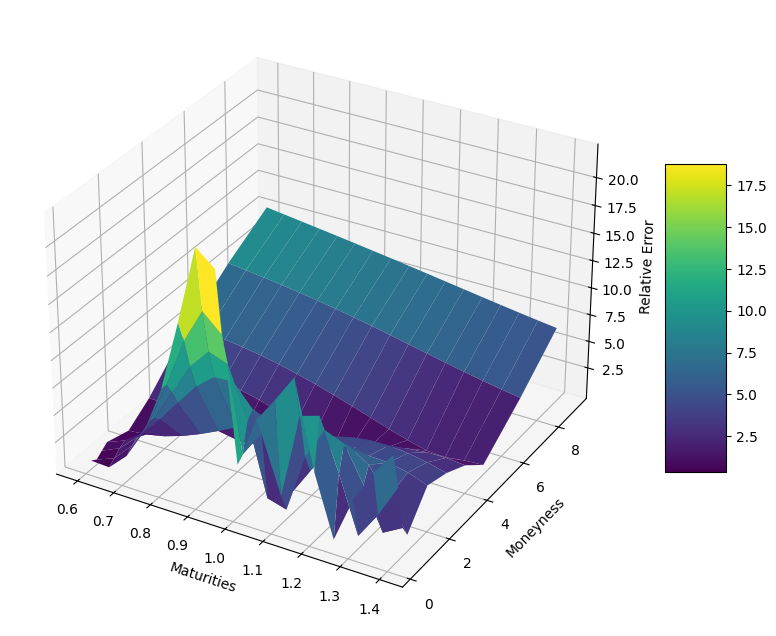

In [14]:
# Calculate the relative error
relative_error = np.abs((implied_vols_opt - IV_target) / IV_target) * 100

# Plotting the relative error surface with swapped axes
X, Y = np.meshgrid(moneyness, maturities)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, relative_error, cmap='viridis')

# Add labels
ax.set_xlabel('Maturities')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Relative Error')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()